# AML Assignment 2

Name- Soham Sengupta

Roll- MDS202241

In [8]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, average_precision_score,average_precision_score
from sklearn.pipeline import Pipeline
import lightgbm as lgb
import xgboost as xgb
import mlflow
import mlflow.sklearn
from mlflow.tracking import MlflowClient
from tqdm.auto import tqdm


In [2]:

train_data = pd.read_csv(r'D:\Applied ML\ASS_2\Data\validation.csv')
validation_data = pd.read_csv(r'D:\Applied ML\ASS_2\Data\train.csv')
test_data = pd.read_csv(r"D:\Applied ML\ASS_2\Data\test.csv")

# Split features and target
X_train = train_data['text']
y_train = train_data['spam']
X_val = validation_data['text']
y_val = validation_data['spam']
X_test = test_data['text']
y_test = test_data['spam']

In [12]:
def train_and_log_model(model_name, X_train, y_train, X_val, y_val, params={},tags={}):
    with mlflow.start_run(run_name=model_name):
        # Define the model pipeline
        if model_name == 'logistic_regression':
            model = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words='english')),
                ('clf', LogisticRegression(random_state=41, **params))
            ])
        elif model_name == 'xgbm':
            model = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words='english')),
                ('clf', xgb.XGBClassifier(class_weight='balanced',random_state=41,**params))
            ])
        elif model_name == 'lightgbm':
            model = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words='english')),
                ('clf', lgb.LGBMClassifier(random_state=41, force_row_wise=True, **params))
            ])
        else:
            raise ValueError("Model name not recognized.")

        # Train the model
        model.fit(X_train, y_train)

        # Evaluate the model
        y_pred_val = model.predict(X_val)
        accuracy = accuracy_score(y_val, y_pred_val)
        aucpr = average_precision_score(y_val, model.predict_proba(X_val)[:, 1])

        # Log parameters, metrics, and model
        mlflow.log_params(params)
        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("aucpr", aucpr)
        mlflow.sklearn.log_model(model, f"model_{model_name}")
        # After training and logging metrics, register the model
        mlflow.sklearn.log_model(model, f"model_{model_name}")

        # Get the run ID
        run_id = mlflow.active_run().info.run_id

        # Create or get the model name in the MLflow Model Registry
        client = MlflowClient()
        try:
            client.create_registered_model(model_name)
        except Exception as e:
            print(f"Model {model_name} already exists in the registry.")

        # Create a new version of the model in the registry
        model_uri = f"runs:/{run_id}/model_{model_name}"
        model_version_info = client.create_model_version(model_name, model_uri, run_id)

        # Add tags to the model version
        tags['Created by'] = 'SohamSG8'  # Replace with your identifier
        for tag_key, tag_value in tags.items():
            client.set_model_version_tag(
                model_name,
                model_version_info.version,
                tag_key,
                tag_value
            )

        print(f"Model {model_name}, version {model_version_info.version} registered in the MLflow Model Registry with tags {tags}.")
        print(f"Model: {model_name}, Accuracy: {accuracy}, AUCPR: {aucpr}")

In [13]:
# Set up MLflow experiment
mlflow.set_experiment("Spam Classification")

Traceback (most recent call last):
  File "c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\mlflow\store\tracking\file_store.py", line 302, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
  File "c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\mlflow\store\tracking\file_store.py", line 395, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
  File "c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\mlflow\store\tracking\file_store.py", line 1303, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
  File "c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\mlflow\store\tracking\file_store.py", line 1296, in _read_helper
    result = read_yaml(root, file_name)
  File "c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\mlflow\utils\file_utils.py", line 303, in read_yaml
    raise 

<Experiment: artifact_location='file:///D:/Applied%20ML/Code/mlruns/2', creation_time=1708345074744, experiment_id='2', last_update_time=1708345074744, lifecycle_stage='active', name='Spam Classification', tags={}>

In [14]:
tags = {
    "Review": "Passed",
    "Ready for Deployment": "Yes"
}

In [15]:
model_names = ['logistic_regression', 'lightgbm', 'xgbm']

In [16]:
# Train and log models with tags
for model_name in tqdm(model_names):
    train_and_log_model(model_name, X_train, y_train, X_val, y_val, tags=tags)

  0%|          | 0/3 [00:00<?, ?it/s]

Model logistic_regression already exists in the registry.
Model logistic_regression, version 5 registered in the MLflow Model Registry with tags {'Review': 'Passed', 'Ready for Deployment': 'Yes', 'Created by': 'SohamSG8'}.
Model: logistic_regression, Accuracy: 0.9257832562917309, AUCPR: 0.9928987222744461
[LightGBM] [Info] Number of positive: 226, number of negative: 748
[LightGBM] [Info] Total Bins 16720
[LightGBM] [Info] Number of data points in the train set: 974, number of used features: 861
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.232033 -> initscore=-1.196868
[LightGBM] [Info] Start training from score -1.196868
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

In [17]:
for model_name in model_names:
    train_and_log_model(model_name, X_train, y_train, X_val, y_val)

Model logistic_regression already exists in the registry.
Model logistic_regression, version 6 registered in the MLflow Model Registry with tags {'Created by': 'SohamSG8'}.
Model: logistic_regression, Accuracy: 0.9257832562917309, AUCPR: 0.9928987222744461
[LightGBM] [Info] Number of positive: 226, number of negative: 748
[LightGBM] [Info] Total Bins 16720
[LightGBM] [Info] Number of data points in the train set: 974, number of used features: 861
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.232033 -> initscore=-1.196868
[LightGBM] [Info] Start training from score -1.196868
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

In [18]:
# keep running this code and....
! mlflow ui

^C


 Access the UI by navigating this url http://localhost:5000  to review the performance metrics, parameters, and details of each run.

Looking at accuracy of the 3 benchmark model in ML-flow we test on lgbm

In [19]:
#Choosing the best model
model_name = "lightgbm" 
model_version = "4"

In [20]:
model_uri = f"models:/{model_name}/{model_version}"
model = mlflow.sklearn.load_model(model_uri)

In [21]:
y_pred = model.predict(X_test)

In [22]:
accuracy = accuracy_score(y_test, y_pred)
aucpr = average_precision_score(y_test, model.predict_proba(X_test)[:, 1])

In [23]:
print(f"Accuracy on test dataset: {accuracy}")
print(f"AUCPR on test dataset: {aucpr}")

Accuracy on test dataset: 0.9662790697674418
AUCPR on test dataset: 0.9649722734020924


NameError: name 'plt' is not defined

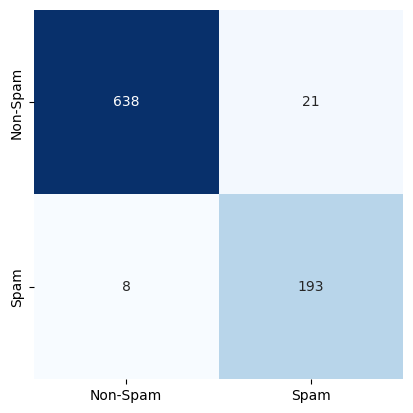

In [25]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(y_test, y_pred)
labels = ['Non-Spam', 'Spam']
 
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=labels, yticklabels=labels)
 
plt.xlabel('Predicted label')
plt.ylabel('Actual label')

In [28]:
y_proba = model.predict_proba(X_test)[:, 1]
pred_prob = list((y_pred))

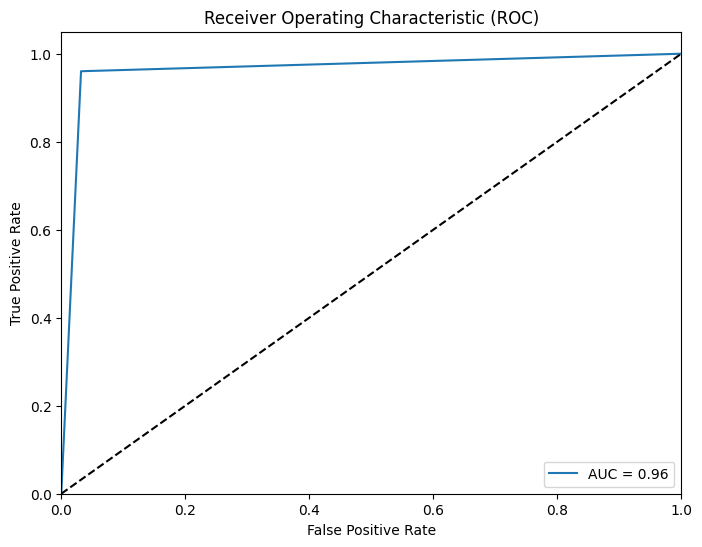

In [32]:
# Calculate ROC curve and AUC score
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
fpr, tpr, thresholds = roc_curve(y_test, pred_prob)
roc_auc = roc_auc_score(y_test, pred_prob)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()